In [1]:
import pathlib

import librosa
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import vocalpy as voc
import xarray as xr

In [2]:
SONGS_ROOT = pathlib.Path('../../../avn/songs')
SONG_PATH = SONGS_ROOT / 'samba.wav'
REFSONG_PATH = SONGS_ROOT / 'simple.wav'

In [3]:
song_audio = voc.Audio.read(SONG_PATH)
refsong_audio = voc.Audio.read(REFSONG_PATH)

In [4]:
def plot_song(song):
    S = librosa.stft(song.data, n_fft=512, hop_length=64)
    S = librosa.amplitude_to_db(np.abs(S))
    
    fig, ax = plt.subplots()
    librosa.display.specshow(S, sr=song.samplerate, hop_length=64, n_fft=512, x_axis = 'time', 
                             y_axis='hz', cmap='viridis', ax=ax)
    ax.set_ylim([0, 11000])
    
    # fig, ax = plt.subplots()
    # librosa.display.specshow(S, sr=song.samplerate, hop_length=64, n_fft=512, x_axis = 'time', 
    #                          y_axis='hz', cmap='viridis', ax=ax)
    # ax.set_ylim([0, 11000])
    # ax.set_xlim([0.345, 0.46])

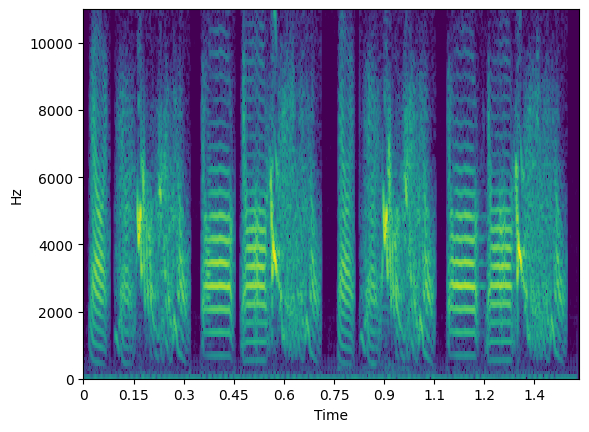

In [5]:
plot_song(song_audio)

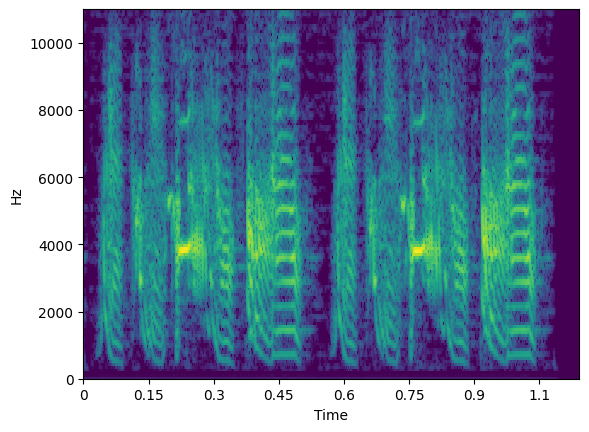

In [6]:
plot_song(refsong_audio)

In [7]:
def distbroad(X, Y):
    """
    Compute the squared dist between two features vector element by element.

    It computes the matrix:
    ```
    (X[0] - Y[0])**2 ; (X[0] - Y[1])**2 ; ... ; (X[0] - Y[m])**2
    (X[1] - Y[0])**2 ; (X[1] - Y[1])**2 ; ... ; (X[1] - Y[m])**2
    ...
    (X[n] - Y[0])**2 ; (X[n] - Y[1])**2 ; ... ; (X[n] - Y[m])**2
    """
    return (X[:, np.newaxis] - Y)**2

In [8]:
def calc_dist_features(feats1, feats2, feat_names=None):
    """Compute the distance between two dict of features."""
    if feat_names is None:
        feat_names = feats1.keys()
    out = dict()
    for fname in feat_names:
        out[fname] = distbroad(feats1[fname], feats2[fname])
    return out

In [9]:
MEDIAN_FEATURES = xr.Dataset(
    {
        'amplitude_modulation': 0.00039675611898210353,
        'amplitude': 82.958846230933801,
        'entropy': -3.4923664803371448,
        'frequency_modulation': 0.84876612812883656,
        'goodness_of_pitch': 0.10728456589138036,
        'pitch': 3042.5634765625
    }
)


MAD_FEATURES = xr.Dataset(
    {
        'amplitude_modulation': 3.1437898652827876,
        'amplitude': 6.4795818349700909,
        'entropy': 0.93547788888390127,
        'frequency_modulation': 0.36812686183136534,
        'goodness_of_pitch': 0.026704864227088371,
        'pitch': 554.991455078125
    }
)


def scale_features(song_features, median_features=None, mad_features=None):
    """Scale features extracted from song.

    
    Subtracts off meadian features then dividing by the 
    absolute median difference.

    It normalizes using the median and the MAD.
    """
    if median_features is None:
        median_features = MEDIAN_FEATURES
    if mad_features is None:
        mad_features = MAD_FEATURES
    scaled = (song_features - median_features) / mad_features
    scaled = scaled.fillna(0)

    return scaled

In [10]:
def compute_L(song_features, refsong_features):
    XA = song_features.drop_vars('amplitude').to_dataframe().values
    XB = refsong_features.drop_vars('amplitude').to_dataframe().values
    n = XA.shape[-1]  # number of dimensions
    # first term gives us *normalized* Euclidean distance
    L = (1 / np.sqrt(n)) * scipy.spatial.distance.cdist(XA, XB)
    return L

In [11]:
def compute_G(L: npt.NDArray, T: int) -> npt.NDArray:
    T = 70
    M = L.shape[0]
    N = L.shape[1]
    G = np.zeros((M, N))  # G2 = G²
    sumG = np.zeros((M, N))
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i <= T or j <= T:
                imin = max(i - T//2, 0)
                jmin = max(j - T//2, 0)
                G[i, j] = np.mean(np.diag(L[imin:i + T//2, jmin:j + T//2]))
                sumG[i, j] = np.sum(np.diag(L[imin:i + T//2, jmin:j + T//2]))
            elif i < M - T*2 and j < N - T * 2:
                sumG[i, j] = (sumG[i - 1, j - 1]
                               - L[(i - 1) - T//2, (j - 1) - T//2]
                               + L[i + (T//2)-1, j + (T//2)-1])
                G[i, j] = sumG[i, j] / T
            else:
                imax = min(i + T//2, M)
                jmax = min(j + T//2, N)
                G[i, j] = np.mean(np.diag(L[i - T//2:imax, j - T//2:jmax]))
    return G

In [12]:
percentile_L = np.array(
   [0.54599694348614791,
    0.77518777088616497,
    0.96136423585440645,
    1.1249268277434958,
    1.2752329009248495,
    1.4167332298057389,
    1.5526729522929845,
    1.6837473735354551,
    1.8110095687311403,
    1.9355849483541776,
    2.0583184987682337,
    2.1791146864612934,
    2.2989471625151658,
    2.4172227039628988,
    2.5351401729993635,
    2.6530292721305426,
    2.7708409109493113,
    2.8892357679493803,
    3.0083625321061414,
    3.1279600016283409,
    3.2483759298059929,
    3.3699565156724272,
    3.4921266180322332,
    3.6167780243852077,
    3.7428257095914272,
    3.8714195260439541,
    4.0018568622075152,
    4.1347538265165245,
    4.2698515531310255,
    4.4073151932231163,
    4.5477757588434793,
    4.6916839853347518,
    4.8381860075590497,
    4.98711459148634,
    5.1394086225374362,
    5.2954320328914273,
    5.4547996706551807,
    5.6179430398258798,
    5.7854261046540572,
    5.9572590855752168,
    6.1338377483850959,
    6.3146271493746315,
    6.5007681318549722,
    6.6910277657111523,
    6.8874206889547853,
    7.0906724064447362,
    7.300012395286176,
    7.5152004073939471,
    7.7371968836548763,
    7.967011361930826,
    8.2047620136833306,
    8.4509495013592719,
    8.7062331313114285,
    8.9712800604516367,
    9.2477747928543685,
    9.5336582732598938,
    9.8305338505622633,
    10.138253445161972,
    10.458841002817021,
    10.791257653213403,
    11.137061676460361,
    11.497245696768685,
    11.873092491563133,
    12.266308444852404,
    12.679232386776823,
    13.112420921729109,
    13.568332330473066,
    14.048288500128841,
    14.55928387445797,
    15.102267078224731,
    15.681442884625884,
    16.296231155797678,
    16.957029976373022,
    17.665667577495515,
    18.428617399959613,
    19.246245413444463,
    20.132748950529415,
    21.089561569797109,
    22.134558706039947,
    23.286903419272555,
    24.557575982844916,
    25.951390666078048,
    27.501403546654991,
    29.240835631697419,
    31.218944050821449,
    33.461626331039497,
    36.010288612155925,
    38.964634502496672,
    42.396666388214271,
    46.505108884603082,
    51.444975606348407,
    57.729261190982633,
    65.846053951969125,
    75.668368184575527,
    88.276625408154615,
    105.67002167093399,
    136.46957950931011,
    199.61077017914533,
    1462.2110958032815,
    100790.20636471517]
)
L_ECDF = scipy.stats.ecdf(percentile_L)

In [13]:
percentile_G = np.array(
   [2.7893880973591956,
    3.2962860661126028,
    3.6763561978570047,
    3.9903175818085401,
    4.2647971429922515,
    4.511390597272193,
    4.7448091439854174,
    4.9668298676608709,
    5.1784511373759079,
    5.3865297586390692,
    5.5900396066874416,
    5.7895356873470076,
    5.9839121582465173,
    6.1718656123535371,
    6.355188436571777,
    6.5325771355187232,
    6.7075597346113218,
    6.8806072514128793,
    7.0528705915985537,
    7.2253815664580694,
    7.3994221676828484,
    7.5746783497994485,
    7.750008451799232,
    7.9259129026605786,
    8.103695818793252,
    8.2824368634698917,
    8.4640366157916525,
    8.6483413756151499,
    8.8351965111336792,
    9.024280345378779,
    9.2166563694487476,
    9.4123031946041635,
    9.612083602171003,
    9.8169694455270005,
    10.027745850777775,
    10.245546956989049,
    10.469980912767237,
    10.69868479822796,
    10.933743969041702,
    11.176611334407898,
    11.429308378097662,
    11.691003205680229,
    11.961836845061267,
    12.242871834376908,
    12.533937062721758,
    12.836717819804822,
    13.150706518971614,
    13.478565408906034,
    13.819487507745411,
    14.170434803895265,
    14.529629145766213,
    14.895863058201339,
    15.271471461930627,
    15.665109973931358,
    16.073441155698379,
    16.49699896439806,
    16.935129898623885,
    17.384317287140082,
    17.851941446996129,
    18.328570258362426,
    18.822320695176455,
    19.333842943405926,
    19.866848273946427,
    20.420853351028764,
    20.983904846323711,
    21.557953956492426,
    22.146661311694615,
    22.761697502739519,
    23.385959835687743,
    24.020880856831976,
    24.66570480393872,
    25.321162718556216,
    25.98985104516359,
    26.674231800901754,
    27.369615207439903,
    28.082936572810492,
    28.841851671964061,
    29.651977028216479,
    30.517950815313291,
    31.454801380892739,
    32.441576898504564,
    33.483331925390246,
    34.601911814177953,
    35.823537115048545,
    37.202677922221881,
    38.896811368115841,
    40.974280589399683,
    43.440704677102296,
    46.404093588109859,
    49.624613928106967,
    54.991635237001617,
    62.972011934528851,
    72.678478140971535,
    91.289159909911859,
    117.36869732319082,
    304.54418965031192,
    503.84382308117381,
    914.95721910297993,
    1643.9748972876507,
    6301.0969631170328]
)
G_ECDF = scipy.stats.ecdf(percentile_G)

In [14]:
def identify_sections(similarity):
    """Identify the blocks of similarity in a song.

    This algorithm is written in step 7 of the appendix of Tchernichovski 2000.
    """
    directions = [(1, 0), (0, 1), (1, 1)]
    sections = []
    visited = np.full(similarity.shape, False, dtype=bool)
    for i, j in sorted(zip(*np.where(similarity > 0))):
        if visited[i, j]:
            continue
        locvisited = np.full(similarity.shape, False, dtype=bool)
        # `locvisited` represents the element of the matrix visited
        # during the creation of one specific section
        # locvisited is recreated every new section because one element
        # can be in two different sections. Though, if an element is
        # already in a section, any section with this element in the upper
        # left corner will be a subsection of the sections containing
        # the element, and therefore, this subsection will be less good.
        #  . . . . . . . . .
        #  . . + - - - - + .
        #  . . | . . . . | .
        #  . + + - - + . | .
        #  . | | . * | . | .
        #  . + + - - + . | .
        #  . . | . . . . | .
        #  . . + - - - - + .
        # The star can be both in the big section or the small section.
        # Thus they need their own locvisited for the flooding.
        # But the section starting from the star will necesserarly be
        # less good than any other section which started before.
        # Therefore it is no use to take the star as the `beg` coordinate
        # of a section. And every element which is already in a section
        # does not need to be taken as `beg`.
        # if it is not clear, just send me a mail ecoffet.paul@gmail.com
        locvisited[i, j] = True
        beg = (i, j)
        end = (i, j)
        flood_stack = [beg]
        # use a flood algorithm to find the boundaries of the section
        # as stated in step 7 of Tchernichovski 2000
        while flood_stack:
            cur = flood_stack.pop()
            locvisited[cur] = True
            # extend the boundaries of the section
            end = (max(end[0], cur[0]), max(end[1], cur[1]))
            for diri, dirj in directions:
                new_coord = (cur[0] + diri, cur[1] + dirj)
                if new_coord[0] < similarity.shape[0] \
                        and new_coord[1] < similarity.shape[1] \
                        and similarity[new_coord] > 0 \
                        and not locvisited[new_coord]:
                    locvisited[new_coord] = True
                    flood_stack.append((new_coord))
        if end[0] - beg[0] > 4 and end[1] - beg[1] > 4:
            sections.append({'beg': beg, 'end': end})
        # If it is already part of a section, it is no use to
        # start exploring from this point, so we put locvisited as
        # visited
        visited = visited | locvisited
    return sections

In [15]:
def similarity(song: voc.Audio, refsong: voc.Audio, threshold: float = 0.01, ignore_silence: bool = True,
               T: int = 70, silence_song_th=None,
               silence_ref_th=None):
    """
    Compute similarity between two songs.

    song - The song to compare
    refsong - The reference song (tutor song)
    threshold - The probability that the global error has this value even if
                the two songs are unrelated. The smaller the threshold, the
                less tolerant is the similar section identification. See
                Tchernichovski et al. 2000, appendix for more details.
    ignore_silence - Should the silence part be taken into account in the
                     similarity measurement.
    T - The number of windows to compute global average. According to
        Tchernichovski et al. 2000, the average must cover around 50ms
        of song. With 70 windows, spaced by 40 samples, and at samplerate of
        44100, the windows cover 63ms. It is also the default value used by
        Sound Analysis Toolbox.


    Return a dict with the keys :
    similarity - a float between 0 and 1
    sim_matrix - a 2D-array of the similarity probability
    glob_matrix - a 2D-array of the global similarity probability
    sections - The sections that are similar and their scores

    Compute the similarity between the song `song` and a reference song
    `refsong` using the method described in Tchernichovski, Nottebohm,
    Ho, Pesaran, & Mitra (2000).
    All the methods are detailed in this article, in the Appendix section.
    The paper is available in open access on several plateforms.

    This implementation follow the rules in the paper and not the ones in SAT.

    ### References:

    Tchernichovski, O., Nottebohm, F., Ho, C. E., Pesaran, B., & Mitra,
    P. P. (2000). A procedure for an automated measurement of song similarity.
    Animal Behaviour, 59(6), 1167–1176. https://doi.org/10.1006/anbe.1999.1416
    """
    if not song.samplerate == refsong.samplerate:
        raise ValueError(
            f"`song` has sampling rate {song.samplerate}  but `refsong` has sampling rate {refsong.samplerate}"
        )

    #########################################################################
    # Compute sound features and scale them (step 2 of Tchernichovski 2000) #
    #########################################################################
    song_features = voc.feature.sat.for_similarity(song)
    refsong_features = voc.feature.sat.for_simlarity(refsong)

    song_features = scale_features(song_features)
    refsong_features = scale_features(refsong_features)

    #################################
    # Compute the L matrix (step 3) #
    #################################
    L = compute_L(song_features, refsong_features)

    #############################
    # Compute G Matrix (step 4) #
    #############################
    G = compute_G(L, T)

    ####################################################################
    # Compute P value and reject similarity hypothesis (steps 5 and 6) #
    ####################################################################
    P_L = L_ECDF.evaluate(L)
    P_G = G_ECDF.evaluate(G)
    S = np.where(P_G < threshold, 1 - P_L, 0)

    #########################################
    # Identify similarity sections (step 7) #
    #########################################
    if ignore_silence:
        # TODO: rewrite this to use amplitude from returned xarray
        amp_song = song_amplitude(song)
        amp_refsong = song_amplitude(refsong)
        # Do not take into account all sounds that are in the first 20
        # percentile. They are very likely to be silent.
        if silence_song_th is None:
            silence_song_th = np.percentile(amp_song, 15)
        S[amp_song < silence_song_th, :] = 0
        if silence_ref_th is None:
            silence_ref_th = np.percentile(amp_refsong, 15)
        S[:, amp_refsong < silence_ref_th] = 0
        len_refsong = S.shape[1] - np.sum(amp_refsong < silence_ref_th)
    else:
        len_refsong = S.shape[1]
    sections = []
    wsimilarity = np.copy(S)
    while True:
        cur_sections = identify_sections(wsimilarity)
        if len(cur_sections) == 0:
            break  # Exit the loop if there is no more sections
        for section in cur_sections:
            beg, end = section['beg'], section['end']
            section['P'] = (np.sum(np.max(S[beg[0]:end[0]+1, beg[1]:end[1]+1], axis=0)) / len_refsong)
        cur_sections.sort(key=lambda x: x['P'])
        best = cur_sections.pop()
        wsimilarity[best['beg'][0]:best['end'][0]+1, :] = 0
        wsimilarity[:, best['beg'][1]:best['end'][1]+1] = 0
        sections.append(best)
    out = {'similarity': np.sum([section['P'] for section in sections]),
           'sim_matrix': S,
           'glob_matrix': glob,
           'sections': sections,
           'G2': G2,
           'L2': L2
           }
    return out

In [16]:
song_features = voc.feature.sat.for_similarity(song_audio)
refsong_features = voc.feature.sat.for_similarity(refsong_audio)

/Users/davidnicholson/Documents/repos/coding/vocalpy/vocalpy/src/vocalpy/feature/sat.py:112: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.sum(P, axis=0)) + baseline
/Users/davidnicholson/Documents/repos/coding/vocalpy/vocalpy/src/vocalpy/feature/sat.py:94: RuntimeWarning: divide by zero encountered in log
  sum_log = np.sum(np.log(P), axis=0)
/Users/davidnicholson/Documents/repos/coding/vocalpy/vocalpy/src/vocalpy/feature/sat.py:95: RuntimeWarning: divide by zero encountered in log
  log_sum = np.log(
/Users/davidnicholson/Documents/repos/coding/vocalpy/vocalpy/src/vocalpy/feature/sat.py:99: RuntimeWarning: invalid value encountered in subtract
  return sum_log / (P.shape[0] - 1) - log_sum
/Users/davidnicholson/Documents/repos/coding/vocalpy/vocalpy/src/vocalpy/feature/sat.py:112: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.sum(P, axis=0)) + baseline


In [17]:
song_features = scale_features(song_features)
refsong_features = scale_features(refsong_features)

In [18]:
song_ftr_df = song_features.drop_vars('amplitude').to_dataframe()
song_ftr_dict = {column: song_ftr_df[column].values for column in song_ftr_df.columns}

refsong_ftr_df = refsong_features.drop_vars('amplitude').to_dataframe()
refsong_ftr_dict = {column: refsong_ftr_df[column].values for column in refsong_ftr_df.columns}

In [19]:
local_dists = calc_dist_features(song_ftr_dict, refsong_ftr_dict)

In [65]:
song_features

<xarray.Dataset>
Dimensions:               (time: 1637)
Coordinates:
  * time                  (time) float64 0.004535 0.005442 ... 1.488 1.488
Data variables:
    amplitude             (time) float64 -8.063 -7.879 -7.759 ... -inf -inf -inf
    pitch                 (time) float64 10.41 10.41 10.41 ... 10.41 10.41 10.41
    goodness_of_pitch     (time) float64 5.323 43.19 28.2 ... -4.017 -4.017
    frequency_modulation  (time) float64 1.959 1.958 1.94 ... -2.306 -2.306
    amplitude_modulation  (time) float64 0.000117 8.423e-05 ... -0.0001262
    entropy               (time) float64 2.285 2.354 2.363 2.432 ... 0.0 0.0 0.0

In [20]:
local_dists['pitch']

array([[  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ],
       [  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ],
       [  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ],
       [  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ],
       [  3.81543149, 164.44630003, 163.95772097, ...,   0.        ,
          0.        ,   0.        ]])

In [21]:
local_dists['pitch'].shape

(1637, 1259)

In [22]:
L2 = np.mean(
    np.array([local_dists[fname] for fname in local_dists.keys()]),
    axis=0
)

In [23]:
L2.shape

(1637, 1259)

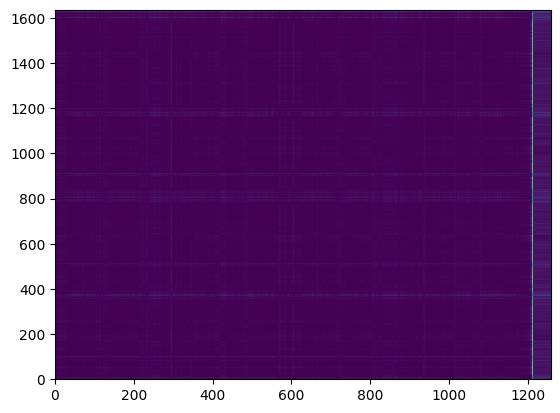

In [25]:
fig, ax = plt.subplots()
ax.pcolormesh(L2)

In [51]:
XA = song_features.drop_vars('amplitude').to_dataframe().values
XB = refsong_features.drop_vars('amplitude').to_dataframe().values
n = XA.shape[-1]  # number of dimensions
# first term gives us *normalized* Euclidean distance
L = (1 / np.sqrt(n)) * scipy.spatial.distance.cdist(XA, XB)

In [57]:
scipy.spatial.distance.cdist(XA, XB)

array([[12.43328878, 16.82628375, 21.47835852, ..., 10.51948128,
        10.51948128, 10.51948128],
       [25.71805372, 29.95374062, 24.38493018, ..., 47.45398359,
        47.45398359, 47.45398359],
       [10.86259244, 17.64508254, 14.10854694, ..., 32.58041312,
        32.58041312, 32.58041312],
       ...,
       [22.02976038, 24.18636822, 29.62992652, ...,  0.        ,
         0.        ,  0.        ],
       [22.02976038, 24.18636822, 29.62992652, ...,  0.        ,
         0.        ,  0.        ],
       [22.02976038, 24.18636822, 29.62992652, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
1 / np.sqrt(n)

0.4472135954999579

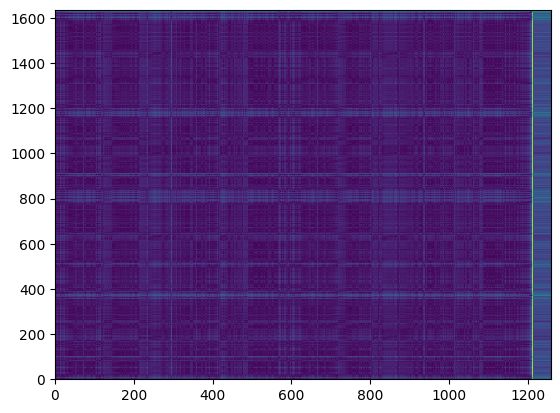

In [52]:
fig, ax = plt.subplots()
ax.pcolormesh(L)

In [69]:
import seaborn as sns

In [70]:
sns.set()
sns.set_context('talk')

array([[<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>]], dtype=object)

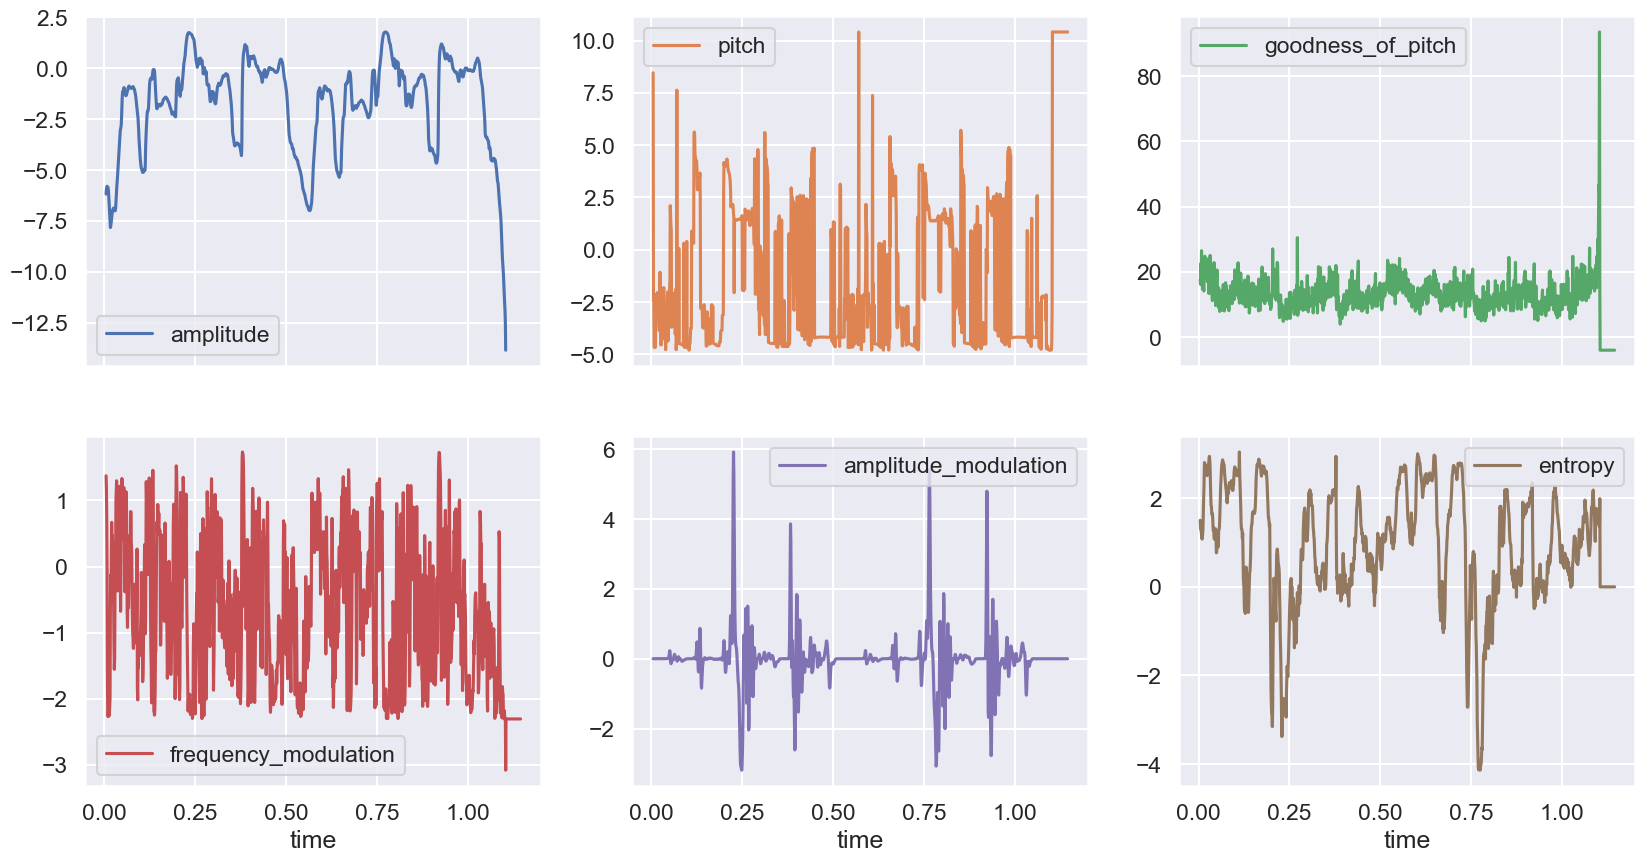

In [71]:
df = refsong_features.to_dataframe()
df.plot(subplots=True, figsize=(20, 10), layout=(2, 3))
#fig.set_size_inches((20, 8))

In [28]:
L = compute_L(song_features, refsong_features)

In [29]:
T = 70
G = compute_G(L, T)

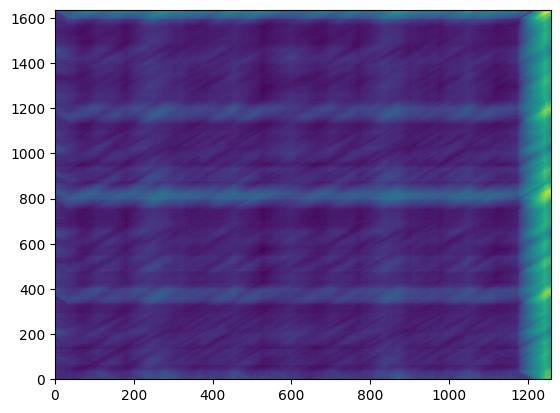

In [30]:
fig, ax = plt.subplots()
ax.pcolormesh(G)

In [31]:
P_L = L_ECDF.cdf.evaluate(L)
P_G = G_ECDF.cdf.evaluate(G)
S = np.where(P_G < 0.01, 1 - P_L, 0)

In [47]:
P_G

array([[0.02, 0.02, 0.02, ..., 0.41, 0.41, 0.41],
       [0.02, 0.02, 0.02, ..., 0.41, 0.41, 0.41],
       [0.02, 0.02, 0.02, ..., 0.41, 0.41, 0.41],
       ...,
       [0.12, 0.13, 0.14, ..., 0.5 , 0.51, 0.52],
       [0.14, 0.15, 0.16, ..., 0.5 , 0.5 , 0.51],
       [0.15, 0.16, 0.16, ..., 0.5 , 0.5 , 0.5 ]])

In [44]:
(P_G < 0.01).sum()

551483

In [48]:
p_val_err_global(G2)

array([[0.6 , 0.6 , 0.6 , ..., 0.95, 0.95, 0.95],
       [0.6 , 0.6 , 0.6 , ..., 0.95, 0.95, 0.95],
       [0.6 , 0.6 , 0.6 , ..., 0.95, 0.95, 0.95],
       ...,
       [0.91, 0.91, 0.92, ..., 0.95, 0.95, 0.95],
       [0.91, 0.91, 0.92, ..., 0.95, 0.95, 0.95],
       [0.91, 0.92, 0.92, ..., 0.95, 0.95, 0.95]])

In [49]:
G2

array([[ 18.67925768,  18.67925768,  18.67925768, ..., 144.8451992 ,
        144.8451992 , 144.8451992 ],
       [ 18.67925768,  18.78796684,  18.78796684, ..., 142.51326397,
        142.51326397, 142.51326397],
       [ 18.67925768,  18.78796684,  18.47560115, ..., 142.82182092,
        142.82182092, 142.51326397],
       ...,
       [ 60.34798762,  62.93912325,  64.00891118, ..., 245.37312439,
        252.00483045, 259.00496463],
       [ 60.18654764,  62.78216771,  63.85619768, ..., 247.32348312,
        247.32348312, 254.19357987],
       [ 61.50870994,  64.06760329,  64.06760329, ..., 250.85068423,
        250.85068423, 250.85068423]])

In [50]:
G

array([[ 3.46385315,  3.46385315,  3.46385315, ..., 11.68155768,
        11.68155768, 11.68155768],
       [ 3.46385315,  3.49966798,  3.49966798, ..., 11.57383549,
        11.57383549, 11.57383549],
       [ 3.46385315,  3.49966798,  3.4777566 , ..., 11.59634934,
        11.59634934, 11.57383549],
       ...,
       [ 5.98280003,  6.16090868,  6.26805383, ..., 14.374456  ,
        14.76295481, 15.17303689],
       [ 6.26600585,  6.43624767,  6.53595122, ..., 14.40725424,
        14.40725424, 14.80745574],
       [ 6.39494398,  6.56160418,  6.56160418, ..., 14.50272929,
        14.50272929, 14.50272929]])

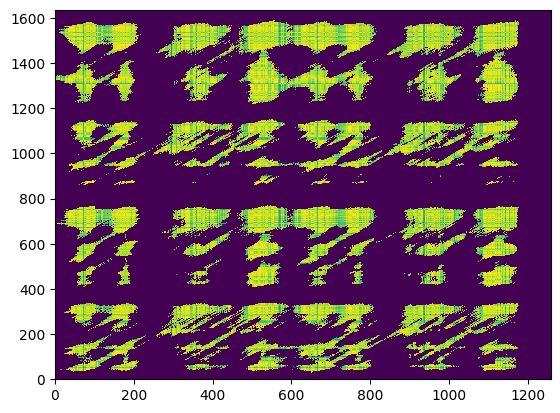

In [58]:
fig, ax = plt.subplots()
ax.pcolormesh(S)

In [33]:
def _compute_G2(song_win, refsong_win, L2, T):
    fast = True
    if fast:
        G2 = np.zeros((song_win.shape[0], refsong_win.shape[0]))  # G2 = G²
        sumG2 = np.zeros((song_win.shape[0], refsong_win.shape[0]))
        for i in range(song_win.shape[0]):
            for j in range(refsong_win.shape[0]):
                if i <= T or j <= T:
                    imin = max(i - T//2, 0)
                    jmin = max(j - T//2, 0)
                    G2[i, j] = np.mean(np.diag(L2[imin:i+T//2, jmin:j+T//2]))
                    sumG2[i, j] = np.sum(np.diag(L2[imin:i+T//2, jmin:j+T//2]))
                elif i < song_win.shape[0] - T*2 \
                        and j < refsong_win.shape[0] - T*2:
                    sumG2[i, j] = (sumG2[i - 1, j - 1]
                                   - L2[(i - 1) - T//2, (j - 1) - T//2]
                                   + L2[i + (T//2)-1, j + (T//2)-1])
                    G2[i, j] = sumG2[i, j] / T
                else:
                    imax = min(i + T//2, song_win.shape[0])
                    jmax = min(j + T//2, refsong_win.shape[0])
                    G2[i, j] = np.mean(np.diag(L2[i - T//2:imax, j - T//2:jmax]))
    else:
        G2 = np.zeros((song_win.shape[0], refsong_win.shape[0]))
        for i in range(song_win.shape[0]):
            for j in range(refsong_win.shape[0]):
                imin = max(0, (i-T//2))
                imax = min(G2.shape[0], (i+T//2))
                jmin = max(0, (j-T//2))
                jmax = min(G2.shape[1], (j+T//2))
                G2[i, j] = np.mean(np.diag(L2[imin:imax, jmin:jmax]))
    return G2

In [34]:
G2 = _compute_G2(np.zeros(song_features.time.shape[0]), np.zeros(refsong_features.time.shape[0]), L2, T=70)

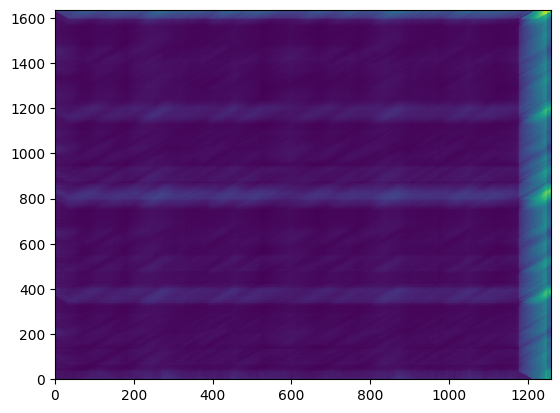

In [35]:
fig, ax = plt.subplots()
ax.pcolormesh(G2)

In [36]:
def p_val_err_local(x):
    """
    Give the probability that the local error could be `x` or less.

    See the notebook `Distrib` to understand the mean and std used.
    """
    assert np.all(x >= 0), 'Errors must be positive.'
    p = np.zeros(x.shape)
    for i in range(len(percentile_L)):
        p[np.where(x > percentile_L[i])] = (i+1)/100
    return p
    # return norm.cdf(np.log(x + 0.01), 2.0893176665431645, 1.3921924227352549)


In [37]:
def p_val_err_global(x):
    """
    Give the probability that the global error could be `x` or less.

    The fit is done using 4 songs, it is available in the notebook `Distrib`
    """
    assert np.all(x >= 0), 'Errors must be positive.'
    p = np.zeros(x.shape)
    for i in range(len(percentile_G)):
        p[np.where(x > percentile_G[i])] = (i+1)/100
    return p

This is where things get fucked up if I used Paul's code.
It's because there's no values for `glob` that are greater than (1 - threshold)

In [38]:
glob = 1 - p_val_err_global(G2)
similarity = np.where(glob > (1 - 0.01),
                      1 - p_val_err_local(L2),
                      0)

In [39]:
glob > (1 - 0.01)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
(glob > 0.98).sum()

13

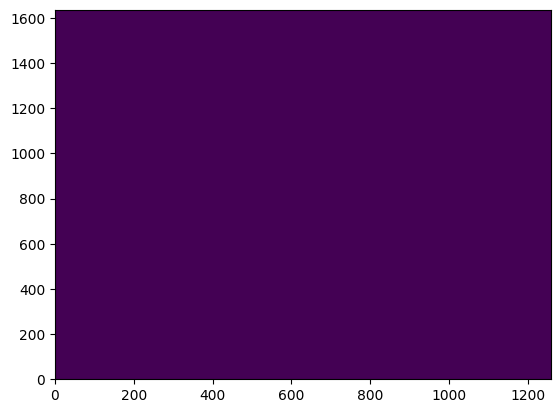

In [97]:
fig, ax = plt.subplots()
ax.pcolormesh(similarity)

In [52]:
import seaborn as sns

In [45]:
import scipy.ndimage

mask = S > 0.
label_im, nb_labels = scipy.ndimage.label(mask)

In [46]:
nb_labels

17411

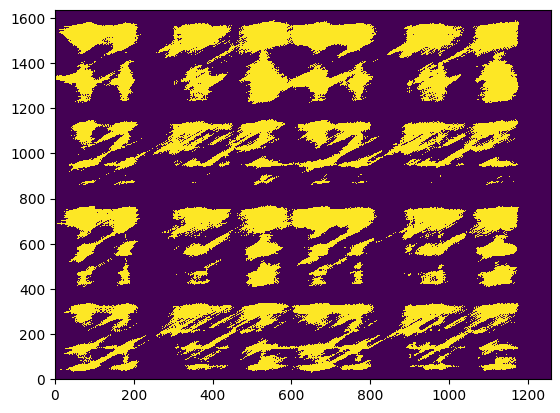

In [48]:
fig, ax = plt.subplots()
ax.pcolormesh(mask)

In [59]:
import scipy.ndimage

In [61]:
labeled_array, num_features = scipy.ndimage.label(S, structure=np.ones(9).reshape(3,3))

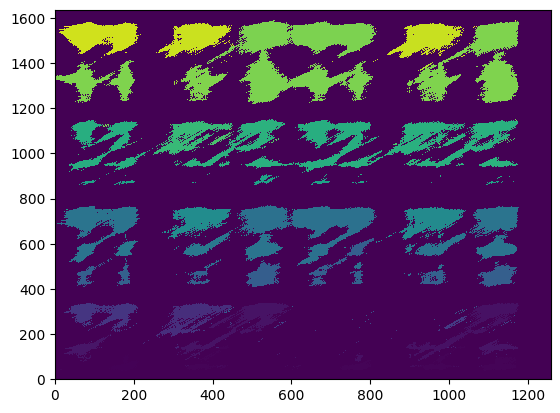

In [62]:
fig, ax = plt.subplots()
ax.pcolormesh(labeled_array)

In [64]:
num_features

1083

In [ ]:

####################################################################
# Compute P value and reject similarity hypothesis (steps 5 and 6) #
####################################################################
glob = 1 - p_val_err_global(G2)
similarity = np.where(glob > (1 - threshold), 1 - p_val_err_local(L2), 0)

#########################################
# Identify similarity sections (step 7) #
#########################################
if ignore_silence:
    # TODO: rewrite this to use amplitude from returned xarray
    amp_song = song_amplitude(song)
    amp_refsong = song_amplitude(refsong)
    # Do not take into account all sounds that are in the first 20
    # percentile. They are very likely to be silent.
    if silence_song_th is None:
        silence_song_th = np.percentile(amp_song, 15)
    similarity[amp_song < silence_song_th, :] = 0
    if silence_ref_th is None:
        silence_ref_th = np.percentile(amp_refsong, 15)
    similarity[:, amp_refsong < silence_ref_th] = 0
    len_refsong = similarity.shape[1] - np.sum(amp_refsong < silence_ref_th)
else:
    len_refsong = similarity.shape[1]
sections = []
wsimilarity = np.copy(similarity)
while True:
    cur_sections = identify_sections(wsimilarity)
    if len(cur_sections) == 0:
        break  # Exit the loop if there is no more sections
    for section in cur_sections:
        beg, end = section['beg'], section['end']
        section['P'] = (np.sum(np.max(similarity[beg[0]:end[0]+1,
                                                 beg[1]:end[1]+1], axis=0))
                        / len_refsong)
    cur_sections.sort(key=lambda x: x['P'])
    best = cur_sections.pop()
    wsimilarity[best['beg'][0]:best['end'][0]+1, :] = 0
    wsimilarity[:, best['beg'][1]:best['end'][1]+1] = 0
    sections.append(best)
out = {'similarity': np.sum([section['P'] for section in sections]),
       'sim_matrix': similarity,
       'glob_matrix': glob,
       'sections': sections,
       'G2': G2,
       'L2': L2
       }